# Assignment 4

In [1]:
import copy
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from numpy.random import randn

import scipy.linalg
from scipy import linalg as la
from scipy.integrate import odeint

import ipywidgets as widgets 
from IPython.display import display, HTML

import sympy as sym
from sympy import Matrix, init_printing
init_printing()

float_formatter = "{:.6f}".format
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})
np.set_printoptions(precision=6)
plt.rcParams["font.serif"] = "cmr12"
plt.rcParams["figure.dpi"] = 150

$\newcommand{\njbu}{\mathbf{u}}
\newcommand{\njbf}{\mathbf{f}}
\newcommand{\njbg}{\mathbf{g}}
\newcommand{\njbh}{\mathbf{h}}
\newcommand{\njba}{\mathbf{a}}
\newcommand{\njbb}{\mathbf{b}}
\newcommand{\njbi}{\mathbf{i}}
\newcommand{\njbe}{\mathbf{e}}
\newcommand{\njbd}{\mathbf{d}}
\newcommand{\njbp}{\mathbf{p}}
\newcommand{\njbq}{\mathbf{q}}
\newcommand{\njbr}{\mathbf{r}}
\newcommand{\njby}{\mathbf{y}}
\newcommand{\njbv}{\mathbf{v}}
\newcommand{\njbw}{\mathbf{w}}
\newcommand{\njbx}{\mathbf{x}}
$

## Solution 1 <font color='red' size=3>[10 points total]</font>


For this problem, the observation function is
$$
\boldsymbol{h}(\boldsymbol{x}) = \left( 
\begin{array}{c}
\tan^{-1}\left(\frac{x_2}{(x_1-l_1)}\right)\\ 
\tan^{-1}\left(\frac{x_2}{(x_1-l_2)}\right) \\ 
\tan^{-1}\left(\frac{x_2}{(x_1-l_3)}\right)
\end{array} \right)
$$

where $\boldsymbol{x}=(x_1,x_2)$.

The code below uses the equations of slide 12-4

In [8]:
sx1,sx2,sl = sym.symbols('x1,x2,l')
fun = sym.atan(sx2/(sx1 - sl))  
numfun = sym.lambdify([sx1,sx2,sl],fun) 
gradfun1 = sym.diff(fun,sx1) #take the gradient symbolically wrt x1
numgradfun1 = sym.lambdify([sx1,sx2,sl],gradfun1) #turn into a bivariate lambda for numpy
gradfun2 = sym.diff(fun,sx2) #take the gradient symbolically wrt x2
numgradfun2 = sym.lambdify([sx1,sx2,sl],gradfun2) #turn into a bivariate lambda for numpy

def h(x1, x2, l):
    return numfun(x1,x2,l)[0]

def H(x1, x2, l):
    return np.array([[numgradfun1(x1,x2,l)[0], numgradfun2(x1,x2,l)[0]]])

# initial guess
x0 = np.vstack(np.array([1500, 500]))
Q0=1000*np.eye(2)

# measurements
y = (np.pi/180)*np.vstack(np.array([30.1, 45.0, 73.6]))

# covars
R = ((np.pi/180)**2)*np.diag([0.01, 0.01 ,0.04])

# l
l = np.vstack(np.array([0, 500, 1000]))

def nllsfit(x0,xk,Q0,R,y,l): 
    hxk=np.array([[h(xk[0],xk[1],l[0])],\
                  [h(xk[0],xk[1],l[1])],\
                  [h(xk[0],xk[1],l[2])]])
    
    Hxk = np.concatenate((H(xk[0],xk[1],l[0]),\
                          H(xk[0],xk[1],l[1]),\
                          H(xk[0],xk[1],l[2])), axis=0)
    
    #See equations of slide 12-4
    Qkp1 = np.linalg.inv(np.linalg.inv(Q0) + Hxk.T@np.linalg.inv(R)@Hxk)
        
    xkp1 = x0 + Qkp1@Hxk.T@np.linalg.inv(R)@(y - hxk - Hxk@(x0-xk))
    
    return  xkp1, Qkp1


xk = x0
Qk = Q0
for i in np.arange(0,200):
  xk,Qk = nllsfit(x0,xk,Q0,R,y,l)

print('Original estimate = \n'+str(x0))
print('Original Covariance = \n'+str(Q0))

print('\n\nFinal estimate = \n'+str(xk))
print('Final Covariance = \n'+str(Qk))


Original estimate = 
[[1500]
 [ 500]]
Original Covariance = 
[[1000.    0.]
 [   0. 1000.]]


Final estimate = 
[[1205.973203]
 [ 702.206236]]
Final Covariance = 
[[10.827304  9.933225]
 [ 9.933225 12.386697]]


<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| incorrect implementation of $\boldsymbol{h}(\boldsymbol{x})$                | -2                                       |
|  incorrect implementation of ${H}_{\boldsymbol{x}}$                  | -2                                       |
| did not converge to $\approx(1205,702)$       | -2                                       |
| incorrect final estimate of $Q$        | -2                                       |

## Solution 2 <font color='red' size=3>[10 points total]</font>

Since $a$ is an unknown constant, we can estimate it by adding it to the state vector with trivial dynamics and a small added process noise - system dynamics are now
$$
\left[ \begin{array}{c} x \\ x_a \end{array} \right]_{k+1} =
\left[ \begin{array}{c} x x_a \\ x_a \end{array} \right]_{k}
$$
The linearized dynamics are
$$
A = \left[ \begin{array}{cc} x_a & x\\ 0 & 1 \end{array} \right]_{\hat xk}
$$
We add a small amount of process noise to the second state to keep the fillter "awake". The measurement process $h(x,x_a)=\sqrt{1+x^2}$ is linearized as
$$
H = \left[ \begin{array}{cc} \frac{x}{(1+x^2)^{1/2}} & 0 \end{array} \right]_{\hat x_k}
$$

With these linearizations, the standard EKF recursion can be implemented in code.

<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| did not add $a$ to state               | -1                                       |
| incorrect state linearization          | -1                                       |
| incorrect measurement linearization    | -1                                       |
| incorrect implementation               | -3                                       |

Error mean = 1.0121228171607832
Error std = 1.987569825077557


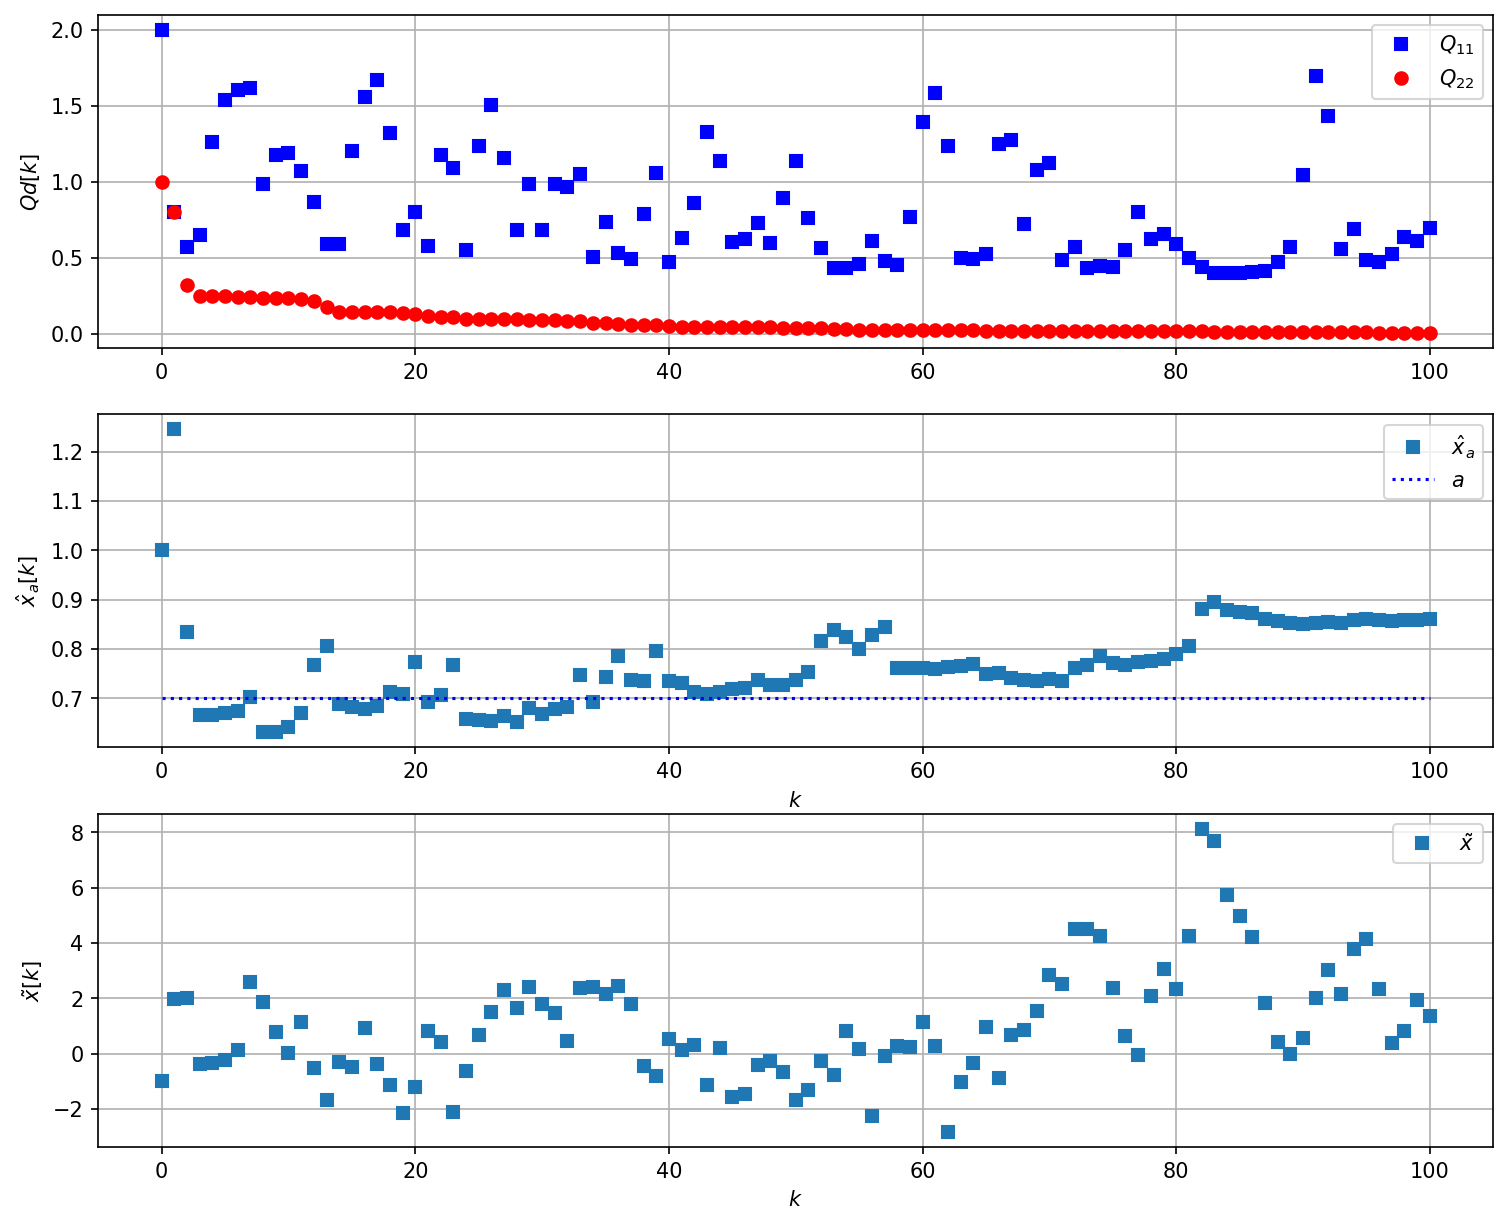

In [2]:
N = 100 # number of steps in sim

x_act_0 = np.array([1]) # actual initial condition
a = 0.7 # actual a (not known)
Q_act = 2

x0 = np.array([x_act_0.item(), 1]) # initial condition
Q0 = np.array([[Q_act, 0],[0, 1]]) # initial state uncertainty

Nx = 2
q = 1
r = 0.5

Wd = np.array([[q, 0],[0, q/100000]]) # process noise (small bit added for second state)
Rd = np.array(r) # disc meas noise

Qdm = np.zeros((Nx,Nx,N+1))
Qdm[:,:,0] = Q0
Xdm = np.zeros((Nx,N+1))
Xdm[:,0] = x0

Xsm = np.zeros((1,N+2))
Xsm[:,0] = np.vstack(x_act_0)+np.sqrt(Q_act)*np.vstack(randn(1)) # random initial pt

for k in np.arange(1,N+1,1):
    # run sim
    Xsm[:,k+1] = a*Xsm[:,k] + np.sqrt(q)*np.vstack(randn(1))
    # sim measurements
    zk = np.sqrt(1 + Xsm[:,k]**2) + np.sqrt(r)*np.vstack(randn(1))

    # linearized dynamics at current estimate 
    Ax = np.array([[Xdm[1,k-1], Xdm[0,k-1]],[0, 1]]) # linearized A matrix
    Cx = np.array([[Xdm[0,k-1]/np.sqrt(1+Xdm[0,k-1]**2), 0]]) # linearized C matrix

    # prop est and cov
    Qdm[:,:,k] = Ax@Qdm[:,:,k-1]@Ax.T+Wd # linearized prop
    Xdm[0,k] = Xdm[0,k-1]*Xdm[1,k-1] # NL prop
    Xdm[1,k] = Xdm[1,k-1]

    Lk = Qdm[:,:,k]@Cx.T/(Cx@Qdm[:,:,k]@Cx.T+Rd) # uses Q[k|k-1]
    Qdm[:,:,k] = (np.eye(2) - Lk@Cx)@Qdm[:,:,k] # creates Q[k|k]
    # transpose on L here for python reasons...
    Xdm[:,k] = Xdm[:,k] + Lk.T*(zk - np.sqrt(1 + Xdm[0,k]**2)) # uses x[k|k-1] to create x[k|k] 

K=np.arange(0,N+1,1)
plt.figure(51,figsize=(12,10))
ax1 = plt.subplot(311)
ax1.plot(K,Qdm[0,0,:],'bs',label=r'$Q_{11}$')
ax1.plot(K,Qdm[1,1,:],'ro',label=r'$Q_{22}$')
plt.ylabel(r'$Qd[k]$')
plt.legend(loc='best')
plt.grid()

ax2 = plt.subplot(312)
ax2.plot(K,Xdm[1,:],'s',label=r'$\hat x_a$')
ax2.plot([0, N],[a, a],'b:',label=r'$a$')
plt.ylabel(r'$\hat x_a[k]$')
plt.xlabel(r'$k$')
plt.legend(loc='best')
plt.grid()

err = Xdm[0,:]-Xsm[0,0:N+1]
print(f'Error mean =',np.mean(err))
print(f'Error std =',np.std(err))
ax3 = plt.subplot(313)
ax3.plot(K,err,'s',label=r'$\tilde x$')
plt.ylabel(r'$\tilde x[k]$')
plt.xlabel(r'$k$')
plt.grid()
plt.legend(loc='best')

plt.tight_layout
plt.show()


## Solution 3 <font color='red' size=3>[10 points total]</font>

a) For the case where $N \to \infty$, the steady-state value of P is a positive (semi)definite solution of the following Riccati equation:

$$
P = Q + A^T \{P-PB[R+B^TPB]^{-1}B^TP\}A
$$

For this scalar system with $b=1$:

$$
p = q + a\{p-p(r+p)^{-1}p\}a = q + a^2(p - \frac{p^2}{p+r})
$$

$$
p = \frac{1}{2}[(q+(a^2-1)r) + \sqrt{(q+(a^2-1)r)^2 + 4qr}] \geq 0
$$

The feedback gain is given by:

$$
F = -[R+B^TPB]^{-1}B^TPA = -(r+p)^{-1}pa = -\frac{ap}{p+r}
$$

$$
F = - \frac{p-q}{ar} = - \frac{\frac{1}{2}[(q+(a^2-1)r) +
\sqrt{(q+(a^2-1)r)^2 + 4qr}]-q}{ar}
$$

For this particular problem, $a=1.05$.

b) For $q=r=1$,

$$
p = 1.6931, F = -0.6601
$$

Backwards recursion:

$$
P_N = H = 2
$$

$$
P_K = Q + A^TP_{K+1}A - A^TP_{K+1}B(R+B^TP_{K+1}B)^{-1}B^TP_{K+1}A
$$

$$
= q + a^2 P_{K+1} - a^2\frac{P_{K+1}^2}{r+P_{K+1}}
$$

$$
F_K = -(R+B^TP_{K+1}B)^{-1}B^TP_{K+1}A = - \frac{a
P_{K+1}}{r+P_{K+1}}
$$

The recursion results are:


In [13]:
n = 1                    # state dim
N = 20                   # LQR time steps
A = np.array([1.05])     # dynamics matrix
B = np.array([1])        # input matrix
H = np.array([2])        # terminal state cost 
P = np.zeros((n,n,N+1))  # cost to go matrix
Q = np.array([1])        # state cost in LQR
R = np.array([1])        # control cost in LQR

# backward recursion for P and F
F = np.zeros((1,n,N+1))  # gains
P[:,:,N] = H             # P initialization
for k in np.arange(N-1,-1,-1):
    P[:,:,k] = Q+A.T*(P[:,:,k+1]-P[:,:,k+1]*B*B.T*P[:,:,k+1]/(R+B.T*P[:,:,k+1]*B))*A
    F[:,:,k] = -B.T*P[:,:,k+1]*A/(R+B.T*P[:,:,k+1]*B)

print('P =',P[:,:,N-6:N].flatten())   
print('F =',F[:,:,N-6:N].flatten())   

P = [1.693127 1.693146 1.693269 1.694075 1.699392 1.735   ]
F = [-0.660121 -0.660139 -0.660256 -0.661024 -0.666088 -0.7     ]


Within 6 iterations, P converges within 5 significant digits.  So,
if N is sufficiently larger than 3, we can ignore the transient.
There is no strict rule, but $N \geq 15$ will be sufficient.

c) The optimal cost is:
$$
J^* = \frac{1}{2} x_0^T P x_0
$$
where P = 1.6931.  The sub-optimal controller,
$$
u_k = -0.4x_k
$$
gives the following cost:
$$
J = \frac{1}{2}x_0^T S_0 x_0
$$
where $S_0$ is determined from the following recursion:
$$
S_N = H = 2
$$
$$
S_K = Q + G^TRG + (A+BG)^TS_{K+1}(A+BG)
$$
$$
= 1+0.16+(0.65)^2S_{K+1} = 1.16+0.4225S_{K+1}
$$
$$
S_0 = \frac{1.16}{1-0.4225} = 2.0087
$$
for large $N$.
$$
\frac{J}{J^*} = \frac{2.0087}{1.6931} = 1.1864
$$
The suboptimal controller gives a 18.64\% increase of the cost
function.

<br>

| <font color='red'>Grading Issue</font>                            | <font color='red'>Point Deduction</font> |
|-------------------------------------------------------------------|------------------------------------------|
| missing/incorrect steady state soln to DARE                       | -2                                       |
| missing/incorrect gain using steady-state $P$                     | -2                                       |
| missing/incorrect backwards recursion                             | -2                                       |
| missing/incorrect discussion on transience                        | -2                                       |
| missing/incorrect work and discussion on sub-optimal control cost | -2                                       |

## Solution 4 <font color='red' size=3>[10 points total]</font>

| <font color='red'>Grading Issue</font>        | <font color='red'>Point Deduction</font> |
|-----------------------------------------------|------------------------------------------|
| missing code that implements time-varying LQR | -2                                       |
| missing code to solve $P_\text{ss}$           | -2                                       |
| missing comparison of $P(t)$ vs $P_\text{ss}$ | -2                                       |
| missing comparison for part (c)               | -2                                       |

In [14]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=3)

Nx = 4                                # state dim
n = 0.00113
dt = 1e-1                            # delta t
Tf = 2*np.pi/n/10                               # final time  
rho = 1e8

Npts = round(Tf/dt)
t = np.linspace(0,Tf,Npts)
tau = Tf - t                         # backwards time for P matrix

# state X = [x dotx y doty]

A = np.array([[0, 1, 0, 0], [3*n**2, 0, 0, 2*n], [0, 0, 0, 1], [0, -2*n, 0, 0]]) # dynamics matrix
B = np.array([[0, 0], [1, 0], [0, 0], [0, 1]])             # input matrix
H = np.diag([1e4/2, 0, 0, 0])          # terminal state cost 
P = np.zeros((Nx,Nx,Npts))              # cost to go matrix
Rxx = np.diag([1, 0, 0.2, 0])     # state cost in LQR
Ruu = rho*np.eye(2)                     # control cost in LQR

def doty(y, t, A, B, Rxx, Ruu):
    Nx = A.shape[0]
    P = y.reshape(Nx,Nx)
    P = (P+P.T)/2
    dotP = P@A+A.T@P+Rxx-P@B@np.linalg.inv(Ruu)@B.T@P
    return dotP.reshape(Nx*Nx,)
    
# integrate P forward in tau (backward in t) from H
sol = odeint(doty, H.reshape(Nx**2,), t, args=(A, B, Rxx, Ruu))
Pss = la.solve_continuous_are(A, B, Rxx, Ruu)

P steady state value


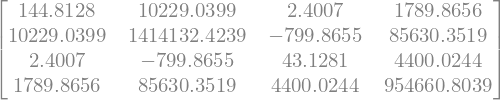

compare to P Numerical


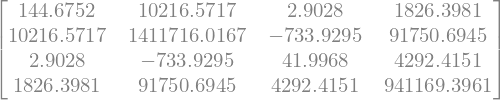

Computed Steady State Gain K


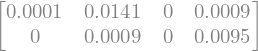

Compare to Numerical Gain K


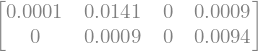

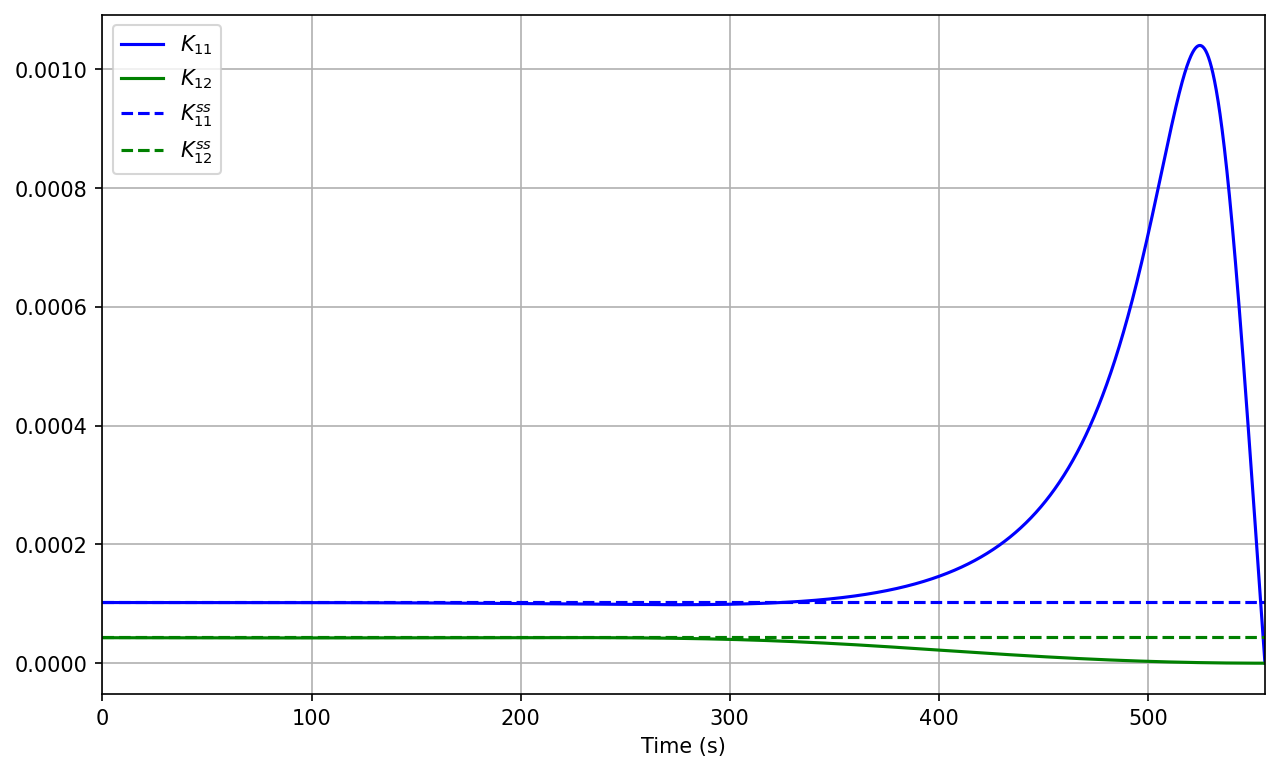

In [15]:
print('P steady state value')
display(Matrix(np.round(Pss,4)))

print('compare to P Numerical')
display(Matrix(np.round(sol[-1,:].reshape(Nx,Nx),4)))

Kss = np.linalg.inv(np.atleast_2d(Ruu))@B.T@Pss
print(r'Computed Steady State Gain K')
display(Matrix(np.round(Kss,4)))

K = np.zeros((2,Nx,Npts))
for II in np.arange(0,Npts):
    K[:,:,Npts-1-II] = np.linalg.inv(np.atleast_2d(Ruu))@B.T@sol[II,:].reshape(Nx,Nx)

print('Compare to Numerical Gain K')
display(Matrix(np.round(K[:,:,0],4)))

plt.figure(3,figsize=(10,6))
plt.plot(t[0:],K[0,0,:], 'b', label=r'$K_{11}$')
plt.plot(t[0:],K[1,2,:], 'g', label=r'$K_{12}$')
plt.plot([0,Tf],[Kss[0,0],Kss[0,0]],'b--',label=r'$K^{ss}_{11}$')
plt.plot([0,Tf],[Kss[1,2],Kss[1,2]],'g--',label=r'$K^{ss}_{12}$')
plt.legend()
plt.xlim([0,Tf])
plt.xlabel(r'Time (s)')
plt.grid()
plt.show()


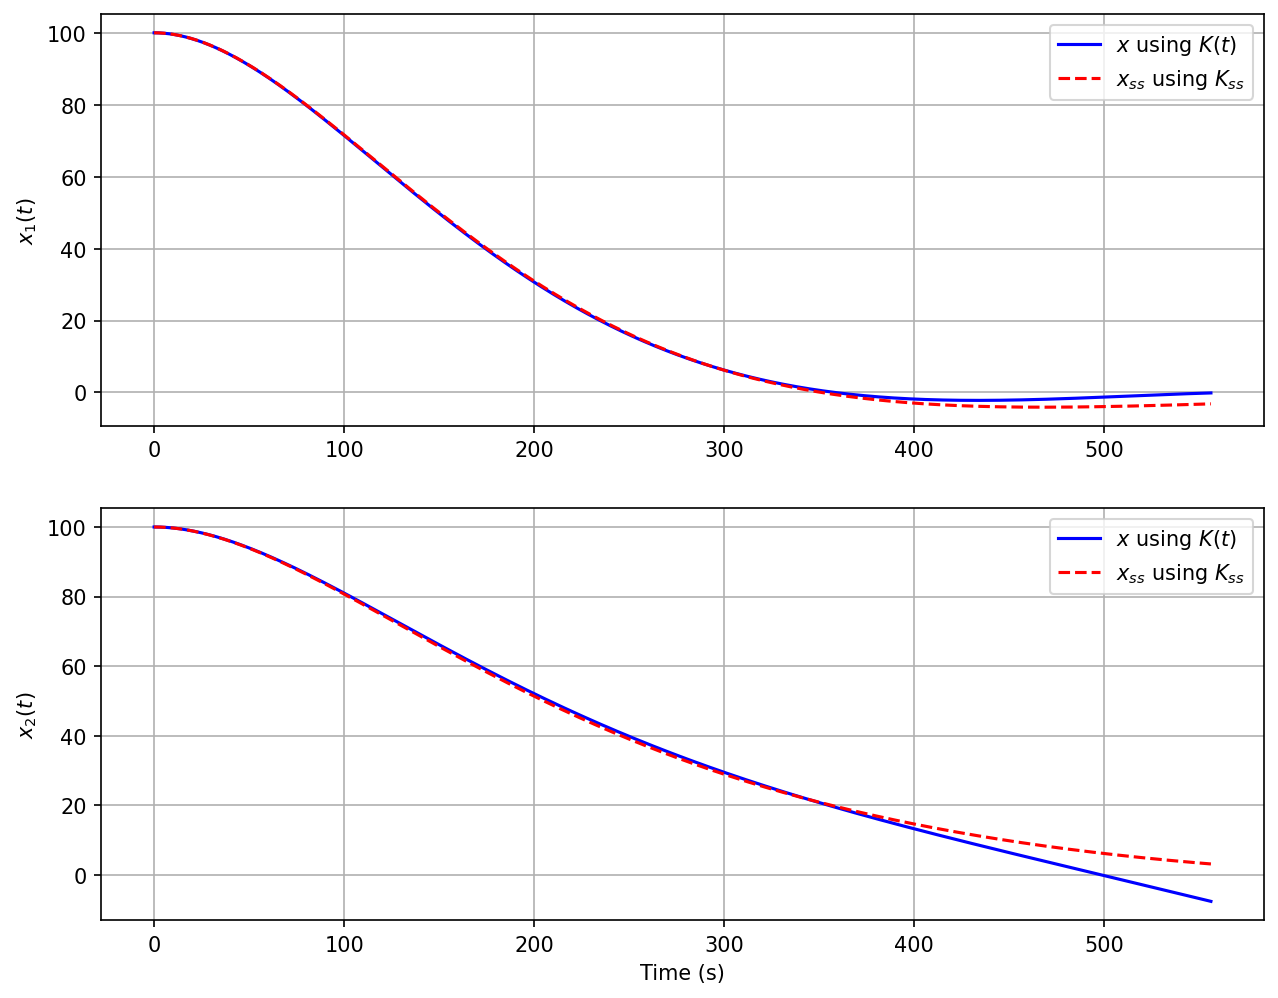

In [16]:
x0 = np.array([100, 0, 100, 0])    # state initial condition
X = np.zeros((Nx,1,Npts))
Xss = np.zeros((Nx,1,Npts))
X[:,0,0] = x0
Xss[:,0,0] = x0

for k in np.arange(0,Npts-1):
    Acl = A - B@K[:,:,k]
    Acl_ss = A - B@Kss
    X[:,0,k+1] = X[:,0,k] + dt*Acl@X[:,0,k]
    Xss[:,0,k+1] = Xss[:,0,k] + dt*Acl_ss@Xss[:,0,k]

plt.figure(3,figsize=(10,8))
ax1 = plt.subplot(211)
ax1.plot(t[0:],X[0,0,:],'b-',label=r'$x$ using $K(t)$')
ax1.plot(t[0:],Xss[0,0,:],'r--',label=r'$x_{ss}$ using $K_{ss}$')
#plt.ylim([0,2.5])
plt.ylabel(r'$x_1(t)$')
plt.grid()
plt.legend(loc='best')
ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(t,X[2,0,:],'b-',label=r'$x$ using $K(t)$')
ax2.plot(t,Xss[2,0,:],'r--',label=r'$x_{ss}$ using $K_{ss}$')
plt.ylabel(r'$x_2(t)$')
plt.legend(loc='best')
plt.grid()
plt.xlabel(r'$k$')
plt.xlabel(r'Time (s)')
plt.show()

## Solution 5 <font color='red' size=3>[10 points total]</font>

See code in `UKF` class below. Note that both the additive and augmented UKF has been implemented. Select which you'd like to execute when running the simulation by changing `augmented=True` or `augmented=False`.

```python
ukf = UKF(robot, x0, Q0, augmented=False)
```

<br>

| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| estimate not track well                | -5                                       |
| no attempt                             | -10                                      |

### Robot Simulation Class

This class simulates the robot using the nonlinear motion and measurement models described above.

In [ ]:
class Robot:
    """
    Velocity-controlled two-wheeled robot (e.g., think Roomba)
    
    The robot has state (x, y, θ) with motion model as
    described in Probabilistic Robotics by Thrun ch. 5d
    """
    def __init__(self, dt, x0, L):
        """
        Constructor
        
        Parameters
        ----------
        dt : float
            time step
        x0 : (3,) np.array
            (unknown) true initial state - (x, y, θ)
        L : (2,m) np.array
            known 2D static landmark positions
        """
        self.dt = dt
        self.L = L
        
        self.x = copy.deepcopy(x0) # unknown true state
        
        # state and control history
        self.xh = [copy.deepcopy(x0)]
        self.uh = []
        
        # (unknown) measurement noise for each landmark
        self.R = np.diag([0.03, 0.05])
        
    @staticmethod
    def W(u, alphas=[0.1, 0.01, 0.01, 0.1]):
        """
        Generate processn noise covariance matrix
        
        The process noise is due to the fact that velocity commands
        are not instantaneously achieved because of effects such
        as wheel slippage, friction, etc.
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        alphas : 4-list
            noise characteristics
            
        Returns
        -------
        W : (2,) np.array
            process noise covariance matrix
        """
        
        # create variance according to noise model
        var1 = alphas[0] * u[0]**2 + alphas[1] * u[1]**2
        var2 = alphas[2] * u[0]**2 + alphas[3] * u[1]**2
        return np.diag([var1, var2])
    
    @staticmethod
    def f(x, u, dt):
        """
        Motion model of robot
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        u : (2,) np.array
            velocity command
            
        Returns
        -------
        xp : (3,) np.array
            propagated state
        """
        # for brevity
        v, ω = u
        sθ = np.sin(x[2])
        cθ = np.cos(x[2])
        sθω = np.sin(x[2] + ω * dt)
        cθω = np.cos(x[2] + ω * dt)

        # propagate state forward
        xp = np.zeros_like(x)
        xp[0] = x[0] - v/ω * sθ + v/ω * sθω
        xp[1] = x[1] + v/ω * cθ - v/ω * cθω
        xp[2] = x[2] + ω * dt
        
        return xp
    
    @staticmethod
    def h(x, L):
        """
        Measurement model for range and bearing sensor
        
        Parameters
        ----------
        x : (3,) np.array
            current state
        L : (p,2) np.array
            true positions of p observed 2D landmarks
            
        Returns
        -------
        z : (2*p,) np.array
            range and bearing measurements to each observed landmark
        """
        p = L.shape[0]
        if len(x.shape) == 1:
            z = np.zeros((2*p,))
        elif len(x.shape) == 2: # handle particle set inputs
            z = np.zeros((2*p,x.shape[1]))
        
        for i, l in enumerate(L):
            z[2*i] = np.linalg.norm(x[:2].reshape((2,-1)) - l.reshape((2,1)), axis=0)
            z[2*i+1] = np.arctan2(l[1] - x[1], l[0] - x[0]) - x[2]

        return z
    
    def move(self, u):
        """
        Physics simulation of robot
        
        Parameters
        ----------
        u : (2,) np.array
            velocity command: (v, ω)
        """

        # add noise to desired commands
        unoisy = np.random.multivariate_normal(u, self.W(u))
        
        # propagate state forward
        self.x = self.f(self.x, unoisy, self.dt)
        
        # keep history
        self.uh.append(copy.deepcopy(unoisy))
        self.xh.append(copy.deepcopy(self.x))
    
    def sense(self):
        """
        Use simulated sensor to gather range and bearing measurements
        
        Only a single landmark is measured. It is selected randomly.
        Data association is assumed solved, i.e., landmarks have unique
        IDs and it is known which landmark a measurement is associated with.
        
        Returns
        -------
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # randomly select p landmarks
        p = 1
        l = np.random.choice(len(self.L), p, replace=False)
        
        # simulate measurements
        z = self.h(self.x, self.L[l])
        
        # add noise
        z += np.random.multivariate_normal(np.zeros(2*p), la.block_diag(*[self.R]*p))
            
        return z, l

In [ ]:
def π(t):
    """
    Control policy to generate velocity commands
    
    Parameters
    ----------
    t : float
        current time
        
    Return
    ------
    u : (2,) np.array
        velocity command (v, ω)
    """
    v =  1.0 + 0.5 * np.cos(2 * np.pi * 0.2 * t)
    ω = -0.2 + 2.0 * np.cos(2 * np.pi * 0.6 * t)
    return np.array([v,ω])

### UKF Implementation - Your Code Here

In [ ]:
class UKF:
    """
    Unscented Kalman Filter
    """
    def __init__(self, robot, x0, Q0, augmented=False, α=1, β=2, κ=0):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object describing the process we are filtering for
        x0 : (3,) np.array
            initial state for filter (ideally as close to actual robot as possible)
        Q0 : (3,3) np.array
            initial estimation error covariance (commensurate with belief in x0)
        augmented : bool
            should use augmented or additive UKF formulation
        α : float
        β : int
        κ : int
        """
        
        # filter state and estimation error covariance
        self.xhat = copy.deepcopy(x0)
        self.Q = copy.deepcopy(Q0)
        
        # filter state and cov history
        self.xhath = [copy.deepcopy(x0)]
        self.Qh = [copy.deepcopy(Q0)]
        
        # construct unscented transform weights
        
        # unscented transform parameters
        self.α = α
        self.β = β
        self.κ = κ
        
        # hold onto robot model for dynamics, landmark positions, etc
        self.robot = robot
        
        # motion and measurement model to use
        # n.b., this assumes we have perfect model knowledge
        self.f = robot.f
        self.h = robot.h
        
        same_noise = True
        self.augmented = augmented
        if same_noise:
            if self.augmented:
                self.W = robot.W # process noise is a fcn of control
                self.R = robot.R
            else:
                self.W = np.diag([1., 1., 1.])*0.1
                self.R = robot.R*10
        else:
            if self.augmented:
                self.W = lambda u: robot.W(u, alphas=[0.1, 0.05, 0.05, 0.1])
                self.R = robot.R
            else:
                self.W = np.diag([1., 1., 1.])*0.1
                self.R = np.diag([0.01, 0.01])*100
    
    def filter_additive(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # dimensions and stuff
        n, = self.xhat.shape  # num states
        k, = u.shape          # num inputs
        mm, = z.shape         # num measurements
               
        # unscented transform weights
        Wm = np.zeros(2 * n + 1)
        Wc = np.zeros(2 * n + 1)
        
        λ = self.α**2 * (n + self.κ) - n
        Wm[:] = 0.5/(n + λ)
        Wc[:] = 0.5/(n + λ)
        Wm[0] = λ/(λ + n)
        Wc[0] = λ/(λ + n) + (1 - self.α**2 + self.β)
        
        #
        # Propagation
        #

        # Generate sigma points
        sqrtQ = np.linalg.cholesky((λ + n) * self.Q).T
        X = np.column_stack([self.xhat, (self.xhat + sqrtQ.T).T, (self.xhat - sqrtQ.T).T])

        # Pass sigma points through motion model
        Xp = self.f(X, u, self.robot.dt)
        
        # Recover Gaussian statistics - mean and covariance
        self.xhat = np.sum(Wm * Xp, axis=1)
        self.Q = ((Xp.T - self.xhat).T * Wc).dot(Xp.T - self.xhat) + self.W
        
        #
        # Update
        #
        
        # Generate new sigma points
        sqrtQ = np.linalg.cholesky((λ + n) * self.Q).T
        Xp = np.column_stack([self.xhat, (self.xhat + sqrtQ.T).T, (self.xhat - sqrtQ.T).T])

        # Pass sigma points through measurement model
        Z = self.h(Xp, self.robot.L[l])

        # Recover Gaussian statistics - mean and covariance
        zhat = np.sum(Wm * Z, axis=1)
        S = ((Z.T - zhat).T * Wc).dot(Z.T - zhat) + self.R

        # Recover cross covariance
        Σ_xz = ((Xp.T - self.xhat).T * Wc).dot(Z.T - zhat)

        # Perform measurement update
        K = Σ_xz @ np.linalg.inv(S)
        self.xhat += K @ (z - zhat)
        self.Q += - K @ S @ K.T
        
    def filter_augmented(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        This version uses the augmented state trick and avoids
        regenerating sigma points for the update step.
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        # dimensions and stuff
        n, = self.xhat.shape  # num states
        k, = u.shape          # num inputs
        mm, = z.shape         # num measurements
        
        # augmented state size
        na = n + k + mm
        
        # unscented transform weights
        Wm = np.zeros(2 * na + 1)
        Wc = np.zeros(2 * na + 1)
        
        λ = self.α**2 * (na + self.κ) - na
        Wm[:] = 0.5/(na + λ)
        Wc[:] = 0.5/(na + λ)
        Wm[0] = λ/(λ + na)
        Wc[0] = λ/(λ + na) + (1 - self.α**2 + self.β)
        
        #
        # Propagation
        #

        # Generate augmented mean and covariance
        μ_a = np.concatenate((self.xhat, np.zeros(k), np.zeros(mm)))
        Σ_a = la.block_diag(self.Q, self.W(u), self.R)

        # Generate sigma points
        sqrtΣ = np.linalg.cholesky((λ + na) * Σ_a).T
        X_a = np.column_stack([μ_a, (μ_a + sqrtΣ.T).T, (μ_a - sqrtΣ.T).T])

        # Pass sigma points through motion model
        X_x, X_u = X_a[0:n,:], X_a[n:n+k,:]
        X_xp = self.f(X_x, (u + X_u.T).T, self.robot.dt)
        
        # Recover Gaussian statistics - mean and covariance
        self.xhat = np.sum(Wm * X_xp, axis=1)
        self.Q = ((X_xp.T - self.xhat).T * Wc).dot(X_xp.T - self.xhat)
        
        #
        # Update
        #

        # Pass sigma points through measurement model
        X_z = X_a[-mm:,:]
        Z = self.h(X_xp, self.robot.L[l]) + X_z

        # Recover Gaussian statistics - mean and covariance
        zhat = np.sum(Wm * Z, axis=1)
        S = ((Z.T - zhat).T * Wc).dot(Z.T - zhat)

        # Recover cross covariance
        Σ_xz = ((X_xp.T - self.xhat).T * Wc).dot(Z.T - zhat)

        # Perform measurement update
        K = Σ_xz @ np.linalg.inv(S)
        self.xhat += K @ (z - zhat)
        self.Q += - K @ S @ K.T
        
    
    def filter(self, u, z, l):
        """
        Applies the UKF at the current time step
        
        Parameters
        ----------
        u : (2,) np.array
            desired velocity command: (v, ω)
        z : (2*len(l),) np.array
            noisy (range, bearing) measurements to len(l) landmarks
        l : int
            the index/label of the measured landmark
        """
        
        if self.augmented:
            self.filter_augmented(u, z, l)
        else:
            self.filter_additive(u, z, l)
        
        # logging
        self.xhath.append(copy.deepcopy(self.xhat))
        self.Qh.append(copy.deepcopy(self.Q))

### Simulation

The following code sets up the simulation loop with the appropriate landmark positions.

In [ ]:
dt = 0.1
tvec = np.arange(0,20+dt,dt)

# initial conditions
x0 = np.array([-5, -3, np.pi/2])
Q0 = np.diag([1., 1., 1.])*1e-3

# known landmark positions
L = np.array([[6., 4.],[-7., 8.],[6., -4.]])

robot = Robot(dt, x0, L)
ukf = UKF(robot, x0, Q0, augmented=False)

In [ ]:
for t in tvec:
    
    # use policy to generate desired command
    u = π(t)
    
    # ------------ Robot simulation (i.e., the plant) ------------
    
    # move the robot
    robot.move(u)
    
    # sense the environment
    z, l = robot.sense()
    
    # ------------------------------------------------------------
    
    # perform UKF localization (i.e., estimate robot state (x, y, θ))
    ukf.filter(u, z, l)

### Plotting Code

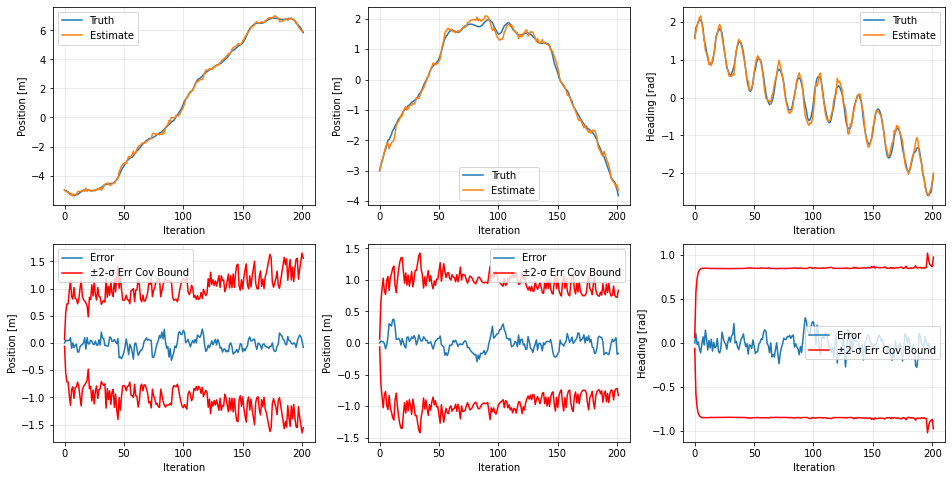

In [ ]:
xgt = np.array(robot.xh)
xhat = np.array(ukf.xhath)
xerr = xgt - xhat
Qdiag = np.array([np.diag(Q) for Q in ukf.Qh]) # variances of est err
σbnd = 2

fig, ax = plt.subplots(2,3,figsize=(16,8))

ylabels = ['Position [m]', 'Position [m]', 'Heading [rad]']

for i in range(3):
    ax[0][i].plot(xgt[:,i],label='Truth')
    ax[0][i].plot(xhat[:,i],label='Estimate')
    ax[0][i].set_xlabel('Iteration')
    ax[0][i].set_ylabel(ylabels[i])
    ax[0][i].legend()
    ax[0][i].grid(alpha=0.3)
    
for i in range(3):
    ax[1][i].plot(xerr[:,i],label='Error')
    ax[1][i].plot( σbnd*np.sqrt(Qdiag[:,i]), label=f'±{σbnd}-σ Err Cov Bound', color='r')
    ax[1][i].plot(-σbnd*np.sqrt(Qdiag[:,i]), color='r')
    ax[1][i].set_xlabel('Iteration')
    ax[1][i].set_ylabel(ylabels[i])
    ax[1][i].legend()
    ax[1][i].grid(alpha=0.3)

### Animation Code for Visualization

In [ ]:
class LocalizationAnimation:
    """
    Utility to visualize robot localization problem
    """
    def __init__(self, robot, ukf):
        """
        Constructor
        
        Parameters
        ----------
        robot : Robot
            Robot object containing state history
        ukf : UKF
            UKF object containing state history
        """
        self.robot = robot
        self.ukf = ukf
    
    def animate(self):
        """
        Generate an animation as an HTML5 video
        """
        X = np.array(self.robot.xh)
        Xhat = np.array(self.ukf.xhath)
        
        dt = self.robot.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8), dpi=100)
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position [m]", fontsize=16)
        ax.set_ylabel("Y position [m]", fontsize=16)
        
        gt_robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(gt_robot)
        gt_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        gt_line, = ax.plot(X[0,0] + gt_dir[0, :], X[0,1] + gt_dir[1, :], 'k', label='Ground Truth')
        gt_traj, = ax.plot(X[0,0], X[0,1], 'k:')
        
        est_robot = plt.Circle((X[0,0], X[0,1]), 1, fill=False, color='r')
        ax.add_artist(est_robot)
        est_dir = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        est_line, = ax.plot(Xhat[0,0] + est_dir[0, :], Xhat[0,1] + est_dir[1, :], 'r', label='Estimate')
        est_traj, = ax.plot(Xhat[0,0], Xhat[0,1], 'r')
        
        ax.plot(self.robot.L[:, 0], self.robot.L[:, 1], 'gD', label='Landmarks')
        
        ax.legend()
        def animate(i):
            gt_dir = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            gt_line.set_data(X[i,0] + gt_dir[0, :], X[i,1] + gt_dir[1, :])
            gt_robot.center = X[i,0], X[i,1]
            gt_traj.set_data(X[:i,0], X[:i,1])
            
            est_dir = np.array([[0, np.cos(Xhat[i, 2])], [0, np.sin(Xhat[i, 2])]])
            est_line.set_data(Xhat[i,0] + est_dir[0, :], Xhat[i,1] + est_dir[1, :])
            est_robot.center = Xhat[i,0], Xhat[i,1]
            est_traj.set_data(Xhat[:i,0], Xhat[:i,1])
            return (gt_line,gt_traj,est_line,est_traj,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim.to_html5_video()

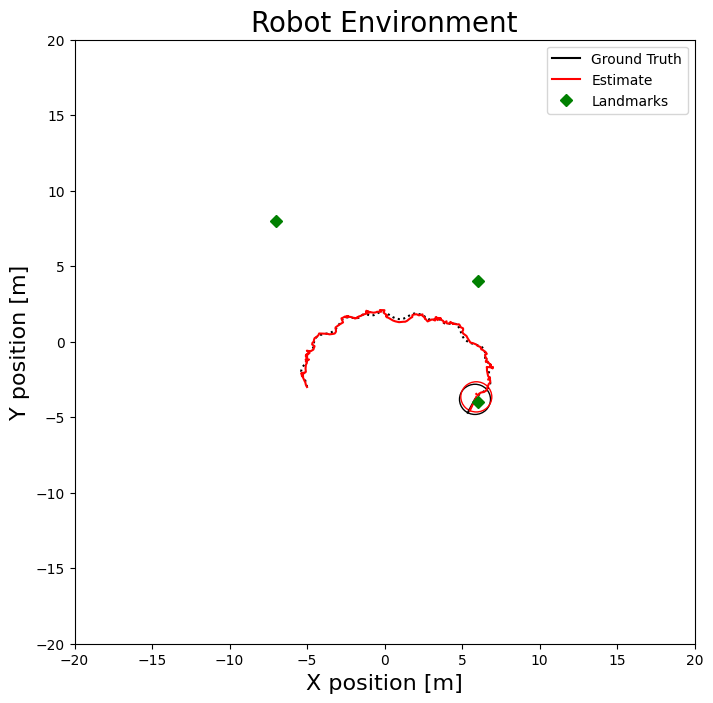

In [ ]:
# generate animation - will take ~20 seconds to make video
ani = LocalizationAnimation(robot, ukf)
HTML(ani.animate())

## Solution LAB <font color='red' size=3>[10 points total]</font>


| <font color='red'>Grading Issue</font> | <font color='red'>Point Deduction</font> |
|----------------------------------------|------------------------------------------|
| incorrect plots of roll/pitch using only gyro integration                | -2                                       |
| incorrect plots of $y_\phi$ and $y_\theta$ (using only accelerometer)    | -2                                      |
| incorrect plots of $\hat{\phi}$ and $\hat{\theta}$ (using the Kalman Filter)    | -2                                      |
| missing plots of the diagonal elements of the estimation error covariances and comparison with steady-state  | -2      |

(note that some of the plots may be different depending on the specific noise levels that you have chosen) 

[[ 10.73 -10.52  -0.    -0.  ]
 [-10.52 510.91   0.     0.  ]
 [ -0.     0.    10.73 -10.52]
 [ -0.     0.   -10.52 510.91]]

[[ 10.73 -10.5    0.     0.  ]
 [-10.5  509.98   0.     0.  ]
 [  0.     0.    10.73 -10.5 ]
 [  0.     0.   -10.5  509.98]]

[[  9.69  -9.49   0.     0.  ]
 [ -9.49 508.98   0.     0.  ]
 [  0.     0.     9.69  -9.49]
 [  0.     0.    -9.49 508.98]]
[[ 1.07315696e+01 -1.05229069e+01 -2.12526538e-14 -3.61537645e-13]
 [-1.05229069e+01  5.10914691e+02  8.06630379e-13  1.53133090e-11]
 [-2.12526538e-14  8.06630379e-13  1.07315696e+01 -1.05229069e+01]
 [-3.61537645e-13  1.53133090e-11 -1.05229069e+01  5.10914691e+02]]


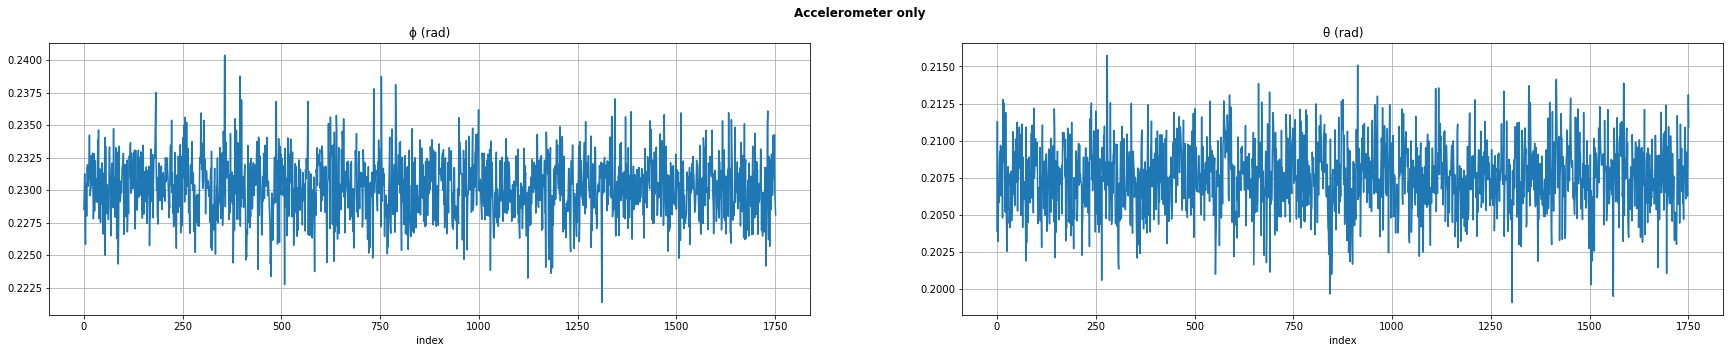

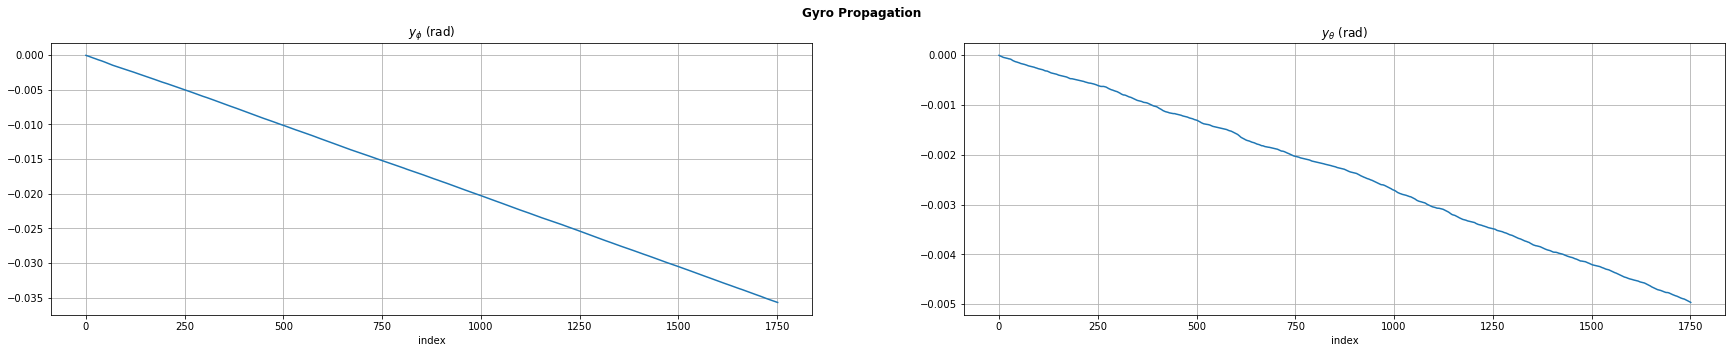

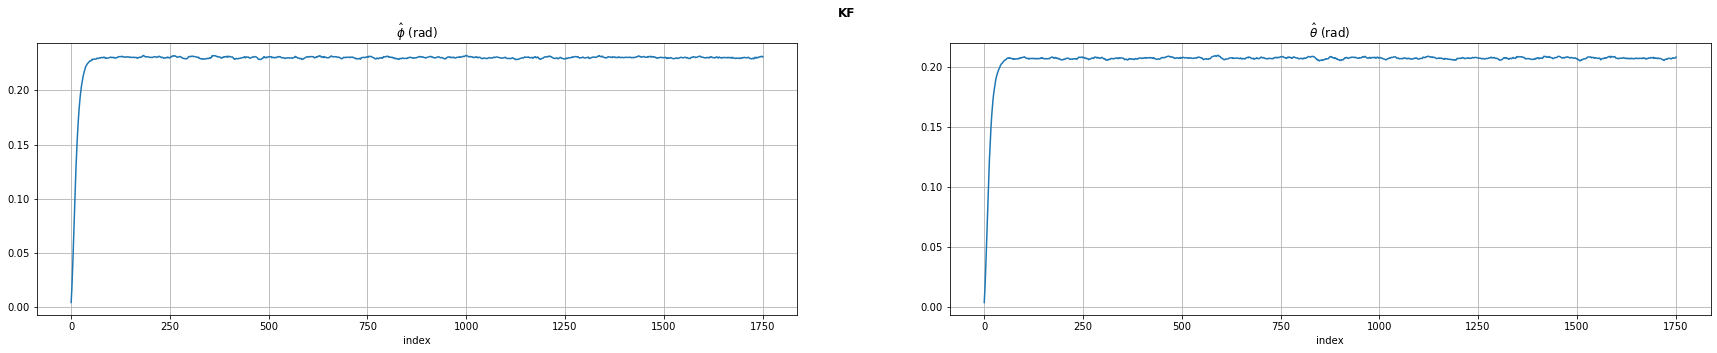

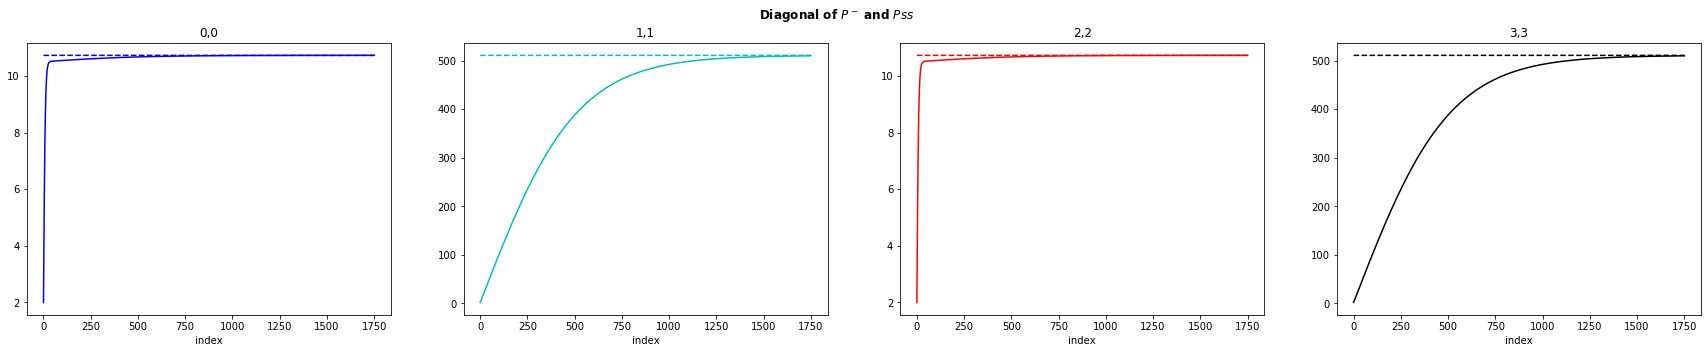

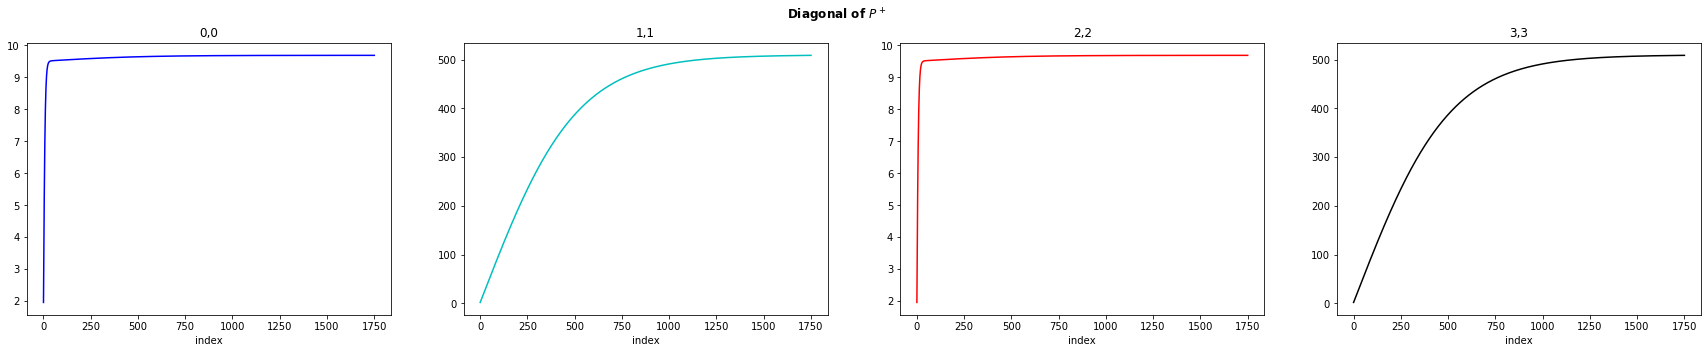

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.linalg

#read the pkl file
with open('hw4_lab_imu_data.pkl', 'rb') as f:
    all_data = pickle.load(f, encoding='latin1')


def get_acc_angles(a):
    """
    Compute tilt angle (roll, pitch) from accelerometer data
    
    Parameters
    ----------
    a : (3,) np.array
        measurement vector from accelerometer
    
    Return
    ------
    y : (2,1) np.array
        [ϕ, θ] in radians
    """
    
    ϕ = np.arctan2(a[1], np.sqrt(a[0]**2 + a[2]**2))
    θ = np.arctan2(-a[0], np.sqrt(a[1]**2 + a[2]**2))
    
    return np.array([[ϕ], [θ]])
    
n_measurements=all_data['acc'].shape[1]
#Plots of only Accelerometer
all_ϕθ=np.empty((2,0))
for i in range(n_measurements):
    ϕθ=get_acc_angles(all_data['acc'][:,i]);
    all_ϕθ=np.concatenate((all_ϕθ,ϕθ), axis=1 )

# print(np.mean(np.diff(all_data['t'], axis=1)))

fig, axes = plt.subplots(1,2,figsize=(30, 5)); fig.suptitle("Accelerometer only",fontweight="bold")
ax=axes[0];
ax.plot(all_ϕθ[0,:])
ax.grid(); ax.set_title('ϕ (rad)'); ax.set_xlabel('index');

ax=axes[1];
ax.plot(all_ϕθ[1,:]);
ax.grid(); ax.set_title('θ (rad)'); ax.set_xlabel('index');


# sampling time
dt = 0.002 #seconds

def runKF(do_update=True, title_figure="", name_var1="", name_var2=""):
    
    # Initialize estimated state and error covariance
    xhat = np.zeros((4,))
    P = np.eye(4)

    # model info
    A = np.array([[1., -dt, 0, 0],[0, 1., 0, 0],[0, 0, 1., -dt],[0, 0, 0, 1.]])
    B = np.array([[dt,0],[0,0],[0,dt],[0,0]])
    C = np.array([[1., 0, 0, 0], [0, 0, 1., 0]])
    Q = np.eye(4) * 1
    R = np.eye(2) * 100

    # for storage
    Pminuses = []
    Ppluses = []
    
    all_xhat=np.empty((4,0))

    for i in range(n_measurements):

        
        # Propagate
        u = all_data['gyr'][:,i][:2].reshape((2,)) #imu.get_gyr()[:2]


        xhat = A @ xhat + B @ u
        P = A @ P @ A.T + Q

        Pminuses.append(P)
        
        if(do_update==True):
            # Update
            S = R + C @ P @ C.T              # innovation covariance
            K = P @ C.T @ np.linalg.inv(S)   # Kalman gain  

            y = get_acc_angles(all_data['acc'][:,i]).reshape(2,) #get_acc_angles(imu.get_acc())
            y_tilde = y - C @ xhat

            xhat = xhat + K @ y_tilde
            P = (np.eye(P.shape[0]) - K @ C) @ P

            Ppluses.append(P)


        all_xhat=np.concatenate((all_xhat, xhat.reshape(4,1)), axis=1)


    fig, axes = plt.subplots(1,2,figsize=(30, 5)); fig.suptitle(title_figure,fontweight="bold")
    ax=axes[0];
    ax.plot(all_xhat[0,:])
    ax.grid(); ax.set_title(name_var1); ax.set_xlabel('index');

    ax=axes[1];
    ax.plot(all_xhat[2,:]);
    ax.grid(); ax.set_title(name_var2); ax.set_xlabel('index');
    
    Pss = scipy.linalg.solve_discrete_are(A.T,C.T,Q,R)
    
    return Pminuses, Ppluses, Pss


runKF(do_update=False, title_figure='Gyro Propagation', name_var1='$y_ϕ$ (rad)', name_var2='$y_θ$ (rad)')
Pminuses, Ppluses, Pss = runKF(do_update=True, title_figure='KF', name_var1='$\hat{ϕ}$ (rad)', name_var2='$\hat{θ}$ (rad)')

with np.printoptions(precision=2, suppress=True):
    print(Pss)
    print()
    print(Pminuses[-1])
    print()
    print(Ppluses[-1])


def plotP(ax, P, name_P, line):
    line1,=ax[0].plot(np.array(P)[:,0,0], 'b'+line, label='$'+name_P+'_{0,0}$'); ax[0].set_title('0,0'); ax[0].set_xlabel('index');
    line2,=ax[1].plot(np.array(P)[:,1,1], 'c'+line, label='$'+name_P+'_{1,1}$'); ax[1].set_title('1,1'); ax[1].set_xlabel('index'); 
    line3,=ax[2].plot(np.array(P)[:,2,2], 'r'+line, label='$'+name_P+'_{2,2}$'); ax[2].set_title('2,2'); ax[2].set_xlabel('index'); 
    line4,=ax[3].plot(np.array(P)[:,3,3], 'k'+line, label='$'+name_P+'_{3,3}$'); ax[3].set_title('3,3'); ax[3].set_xlabel('index'); 

    
fig1, ax1 = plt.subplots(1,4, figsize=(30,5))    
print(Pss)
fig1.suptitle('Diagonal of $P^-$ and $Pss$',fontweight="bold")
plotP(ax1, Pminuses, 'P^-','-')
plotP(ax1, [Pss]*len(Pminuses), 'Pss^-','--')
ax1[0].grid();ax1[1].grid();ax1[2].grid();ax1[3].grid() 

fig2, ax2 = plt.subplots(1,4, figsize=(30,5))
fig2.suptitle('Diagonal of $P^+$',fontweight="bold")
plotP(ax2, Ppluses, 'P^+','-')
ax1[0].grid();ax1[1].grid();ax1[2].grid();ax1[3].grid() 


# fig1, ax = plt.subplots(1,1, figsize=(30,5))    
# # note that before updating, covariance is larger than after updating
# ax.plot(np.array(Pminuses)[:,0,0] - np.array(Ppluses)[:,0,0], 'b')
# ax.plot(np.array(Pminuses)[:,1,1] - np.array(Ppluses)[:,1,1], 'c')
# ax.plot(np.array(Pminuses)[:,2,2] - np.array(Ppluses)[:,2,2], 'r--')
# ax.plot(np.array(Pminuses)[:,3,3] - np.array(Ppluses)[:,3,3], 'k--')
# ax.set_ylabel('$P^--P^+$')
# ax.set_xlabel('Iteration')
# ax.grid()